In [199]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time

In [200]:
import yfinance as yf

# Fetch and prepare data
btc = yf.download('BTC-USD', start='2015-01-01', end=pd.Timestamp.today().strftime('%Y-%m-%d'))

btc = btc.reset_index()  # Make Date a regular column
btc.columns = btc.columns.droplevel(1)  # Remove the Ticker level from column
btc = btc.rename(columns={'Close':'price', 'Date':'date', 'Volume':'volume'})  # Rename Price

btc = btc[['date', 'price', 'volume']]

[*********************100%***********************]  1 of 1 completed


In [201]:
from ta.momentum import RSIIndicator

# Simple Moving Average
window = 14

# Relative Strength Index
btc['rsi_14'] = RSIIndicator(btc['price'], window=window).rsi()

# Price change percentages
btc['daily_pct_change'] = btc['price'].pct_change()

# Moving Average
btc['ma5'] = btc['price'].rolling(5).mean()

# Drop NaN values
btc = btc.dropna()

In [202]:
# Prepare data for modeling
forecast_horizon = 1

# Target is the future price
#btc['target'] = btc['price'].pct_change()
btc['target'] = btc['ma5'].pct_change()

# Remove rows where target is NaN (end of dataset)
btc = btc.dropna()

In [203]:
import requests
from io import StringIO

#BTC On chain metrics
#source: https://www.blockchain.com/en/explorer

#difficulty
url_diff = 'https://api.blockchain.info/charts/difficulty?timespan=all&rollingAverage=1days&start=2010-01-01&format=json'
url_hash = 'https://api.blockchain.info/charts/hash-rate?timespan=all&rollingAverage=1days&start=2010-01-01&format=json'

def get_chain_metrics(url, column_name):
    response = requests.get(url)
    chain_m = []

    if response.status_code == 200:
        data = response.json()
        chain_m = pd.DataFrame(data['values']).copy()
    
        # Convert and format columns
        chain_m['date'] = pd.to_datetime(chain_m['x'], unit='s')
        chain_m = chain_m[['x', 'y', 'date']] \
             .rename(columns={
                 'x': 'time_sec',
                 'y': column_name
             })
    
        #fill in between values
        # First, set the time_sec as the index to create a complete time series
        chain_m.set_index('time_sec', inplace=True)

        # calculate days to offset (data is often not of the same day as today)
        current_timestamp = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0).timestamp()
        day_offset = int(current_timestamp) - chain_m.index.max()

        # Create a complete index with all seconds in the range (or whatever your interval should be)
        full_index = pd.RangeIndex(start=chain_m.index.min(), stop=chain_m.index.max() + 1, step=86400)  # daily data
        
        # Reindex to create missing values for all time points
        chain_m = chain_m.reindex(full_index)
        
        # Now interpolate the missing values
        chain_m[column_name] = chain_m[column_name].interpolate(method='linear')  # linear interpolation between points
        
        # For the date column, we can forward fill or create proper dates
        # and offset timestep so last entry matches with todays date
        chain_m['date'] = pd.to_datetime(chain_m.index + day_offset, unit='s')
        chain_m['date'] = chain_m['date'].apply(lambda x : pd.to_datetime(x.date()))
        
        # Reset index
        chain_m.reset_index(inplace=True)
        chain_m.rename(columns={'index': 'time_sec'}, inplace=True)
        chain_m = chain_m.drop(columns=['time_sec'])
        
        print(chain_m.head(10))
        return chain_m
        
    else:
        print(f"Error: {response.status_code}")

diff_df = get_chain_metrics(url_diff, 'difficulty')
hash_df = get_chain_metrics(url_hash, 'hash_rate')

print(diff_df.tail())
print(hash_df.tail())

   difficulty       date
0     1.18290 2010-01-05
1     1.18290 2010-01-06
2     1.18290 2010-01-07
3     1.18290 2010-01-08
4     1.18290 2010-01-09
5     1.18290 2010-01-10
6     1.18290 2010-01-11
7     1.18290 2010-01-12
8     1.18290 2010-01-13
9     1.21344 2010-01-14
   hash_rate       date
0   0.000008 2010-01-05
1   0.000008 2010-01-06
2   0.000008 2010-01-07
3   0.000009 2010-01-08
4   0.000009 2010-01-09
5   0.000010 2010-01-10
6   0.000010 2010-01-11
7   0.000011 2010-01-12
8   0.000011 2010-01-13
9   0.000011 2010-01-14
        difficulty       date
5640  1.269823e+14 2025-06-15
5641  1.268396e+14 2025-06-16
5642  1.266969e+14 2025-06-17
5643  1.265541e+14 2025-06-18
5644  1.264114e+14 2025-06-19
         hash_rate       date
5640  9.342239e+08 2025-06-15
5641  9.300320e+08 2025-06-16
5642  9.258401e+08 2025-06-17
5643  9.216481e+08 2025-06-18
5644  9.174562e+08 2025-06-19


In [204]:
#Fear and Greed Index data
import requests
from io import StringIO

#source: https://alternative.me/crypto/fear-and-greed-index/
url = 'https://api.alternative.me/fng/?limit=0'
response = requests.get(url)

if response.status_code == 200:
    data_r = response.json()
    df_response = pd.DataFrame(data_r['data'])

    # Convert and format columns
    df_response['date'] = pd.to_datetime(df_response['timestamp'], unit='s')
    df_response = df_response[['value', 'value_classification', 'date']] \
         .rename(columns={
             'value': 'fng_value',
             'value_classification': 'classification'
         })

    df_response = df_response[['fng_value', 'date']]
    print(df_response.head(10))
    
else:
    print(f"Error: {response.status_code}")

  fng_value       date
0        57 2025-06-19
1        52 2025-06-18
2        68 2025-06-17
3        61 2025-06-16
4        60 2025-06-15
5        63 2025-06-14
6        61 2025-06-13
7        71 2025-06-12
8        72 2025-06-11
9        71 2025-06-10


C:\Users\joseh\AppData\Local\Temp\ipykernel_24728\1996290388.py:14: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_response['date'] = pd.to_datetime(df_response['timestamp'], unit='s')


In [205]:
df_response['fng_value'] = df_response['fng_value'].apply(lambda x: float(x))
fng_df = df_response.copy()
fng_df.tail(10)

,fng_value,date
2682,54.0,2018-02-10
2683,44.0,2018-02-09
2684,30.0,2018-02-08
2685,36.0,2018-02-07
2686,8.0,2018-02-06
2687,11.0,2018-02-05
2688,24.0,2018-02-04
2689,40.0,2018-02-03
2690,15.0,2018-02-02
2691,30.0,2018-02-01


In [206]:
data_2018 = btc.merge(fng_df, on='date', how='outer')  #merge
data_2018 = data_2018.dropna()
data_2018.head()

,date,price,volume,rsi_14,daily_pct_change,ma5,target,fng_value
1113,2018-02-01,9170.540039,9.959400e+09,32.505630,-0.102783,10516.127930,-0.041388,30.0
1114,2018-02-02,8830.750000,1.272690e+10,31.214760,-0.037052,9925.017969,-0.056210,15.0
1115,2018-02-03,9174.910156,7.263790e+09,34.070623,0.038973,9500.719922,-0.042750,40.0
1116,2018-02-04,8277.009766,7.073550e+09,30.511391,-0.097865,9134.861914,-0.038508,24.0
1117,2018-02-05,6955.270020,9.285290e+09,26.176396,-0.159688,8481.695996,-0.071503,11.0


In [207]:
data_2018 = data_2018.merge(diff_df, on='date', how='outer')
data_2018 = data_2018.merge(hash_df, on='date', how='outer')
data_2018 = data_2018.dropna()

data_2018.tail()

,date,price,volume,rsi_14,daily_pct_change,ma5,target,fng_value,difficulty,hash_rate
5639,2025-06-14,105472.406250,3.800787e+10,49.892015,-0.005830,107287.257812,-0.008908,63.0,1.269823e+14,9.421143e+08
5640,2025-06-15,105552.023438,3.674431e+10,50.112398,0.000755,106346.215625,-0.008771,60.0,1.269823e+14,9.342239e+08
5641,2025-06-16,106796.757812,5.036663e+10,53.551879,0.011793,105968.242188,-0.003554,61.0,1.268396e+14,9.300320e+08
5642,2025-06-17,104601.117188,5.596409e+10,47.350426,-0.020559,105702.654688,-0.002506,68.0,1.266969e+14,9.258401e+08
5643,2025-06-18,104883.328125,4.731809e+10,48.181050,0.002698,105461.126562,-0.002285,52.0,1.265541e+14,9.216481e+08


In [208]:
data_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2691 entries, 2949 to 5643
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2691 non-null   datetime64[ns]
 1   price             2691 non-null   float64       
 2   volume            2691 non-null   float64       
 3   rsi_14            2691 non-null   float64       
 4   daily_pct_change  2691 non-null   float64       
 5   ma5               2691 non-null   float64       
 6   target            2691 non-null   float64       
 7   fng_value         2691 non-null   float64       
 8   difficulty        2691 non-null   float64       
 9   hash_rate         2691 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 231.3 KB


In [209]:
# Features and target
X = data_2018.drop(columns=['target', 'date', 'price', 'daily_pct_change'])
y = data_2018['target']

In [210]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

# Train XGBoost model
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [211]:
cv_params = {'max_depth': [4, 6],
             'min_child_weight': [3, 5],
             'learning_rate': [0.001, 0.01, 0.1],
             'n_estimators': [1000, 2000],
             'subsample': [0.6, 0.8],
             'colsample_bytree': [0.7]
            }

In [212]:
cv_params = {'max_depth': [16],
             'min_child_weight': [3],
             'learning_rate': [0.1],
             'n_estimators': [4000],
             'subsample': [1.0],
             'colsample_bytree': [0.7]
            }

In [213]:
scoring = {'r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'}

In [214]:
"""
# Create XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.001,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42
)
"""

"\n# Create XGBoost model\nmodel = xgb.XGBRegressor(\n    objective='reg:squarederror',\n    n_estimators=1000,\n    learning_rate=0.001,\n    max_depth=4,\n    subsample=0.8,\n    colsample_bytree=0.8,\n    early_stopping_rounds=50,\n    random_state=42\n)\n"

In [215]:
import xgboost as xgb

# Create XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    #early_stopping_rounds=50,
    random_state=114
)

In [216]:
xgb_cv = GridSearchCV(model,
                      cv_params,
                      scoring = 'neg_mean_squared_error',
                      cv = 5,
                      verbose = 1
                     )

In [217]:
#%%time

# Train model
xgb_cv.fit(
    X_train, y_train,
    #eval_set=[(X_test, y_test)],
    verbose=1
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.1],
                         'max_depth': [16], 'min_child_weight': [3],
                         'n_estimators': [4000], 'subsample': [1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [218]:
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 16,
 'min_child_weight': 3,
 'n_estimators': 4000,
 'subsample': 1.0}

In [219]:
predictions = xgb_cv.predict(X_test)
print(predictions[-10:])

test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Test RMSE: {test_rmse:.2f}')

[ 7.3579224e-03  3.8763857e-03 -1.6697346e-05 -3.0650867e-03
 -1.5439594e-03  1.1753041e-03  2.0223612e-03 -2.0124384e-03
 -4.2460635e-03  3.7738896e-04]
Test RMSE: 0.01


In [220]:
# Calculate Pearson Coefficient
r_coef = np.corrcoef(y_test, predictions)[0, 1]
print(f"Train - Pearson correlation coefficient: {r_coef:.4f}")

Train - Pearson correlation coefficient: 0.6621


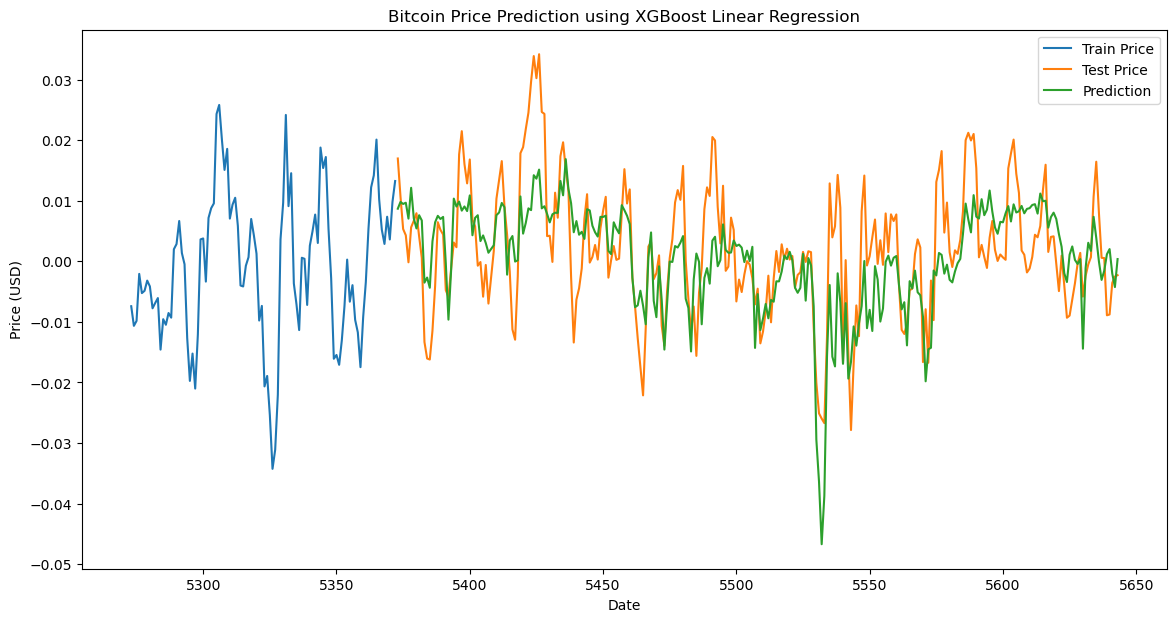

In [221]:
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(14, 7))

# Plot baseline and predictions
plt.plot(y_train.index[-100:], y_train[-100:], label='Train Price')
plt.plot(y_test.index, y_test, label='Test Price')
plt.plot(y_test.index, predictions, label='Prediction')
plt.title('Bitcoin Price Prediction using XGBoost Linear Regression')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

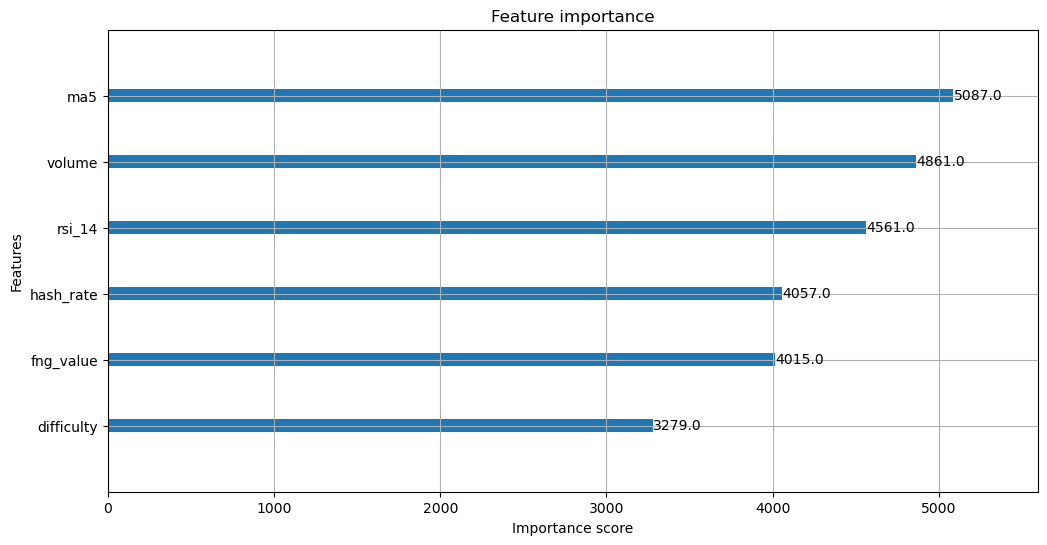

In [222]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(xgb_cv.best_estimator_, max_num_features=8, ax=ax)
plt.show();

In [223]:
features = data_2018.drop(columns=['target', 'date', 'price', 'daily_pct_change']).columns
print(features)

Index(['volume', 'rsi_14', 'ma5', 'fng_value', 'difficulty', 'hash_rate'], dtype='object')


In [275]:
import random

# Make future predictions
days_to_predict = 30

#data_sequence = data_2018.loc[data_2018.index[-1], features].copy()
#data_sequence = pd.DataFrame(data_sequence).transpose().reset_index().drop(columns=['index'])
data_sequence = data_2018.drop(columns=['target', 'date', 'price', 'daily_pct_change']).copy()
data_full = data_2018.copy()

# Create a copy of the last available data point
#last_data = btc.iloc[-1:].copy()
#last_data = last_data.reset_index()
#last_data = last_data.drop(columns=['date'])

predictions = []
dates = []

#Create dataframe for days_to_predict
for i in range(days_to_predict):
    last_row = data_sequence.iloc[-1:].copy()
    #print(last_row)

    #get prediction for the day
    pred = xgb_cv.predict(last_row)[0]
    print(pred)

    #add predicted target to full_data
    last_price = data_full.loc[data_full.index[-1], 'price']

    #print(pd.to_datetime(data_full.loc[data_full.index[-1], 'date']).timestamp())
    last_date = pd.to_datetime(data_full.loc[data_full.index[-1], 'date']).timestamp()
    next_date = last_date + 86400 #Add a day to timestamp
    next_date = pd.to_datetime(next_date, unit='s')

    predictions.append((1 + pred) * last_price)
    dates.append(next_date)
    
    predicted_row = pd.DataFrame({'target': [pred], 
                                  'rsi_14': [0], 
                                  'volume': [data_full['volume'].iloc[-7 +i] * 0.004], 
                                  #'rolling_mean_7': [0], 
                                  #'rolling_std_7': [0], 
                                  'fng_value': [data_full['fng_value'].iloc[-1 +i]], 
                                  'daily_pct_change': [pred], 
                                  'date': [next_date],
                                  'price': [(1 + pred) * last_price],
                                  'ma5': [(1 + pred) * last_price],
                                  'difficulty': [data_full['difficulty'].iloc[-1] * (random.random() * .02 + 1)],
                                  'hash_rate': [data_full['hash_rate'].iloc[-1] * (random.random() * .02 + 1)]})
    data_full = pd.concat([data_full, predicted_row], ignore_index=True)
    
    #calculate metrics
    #data_full.loc[data_full.index[-1], 'volume'] = data_full['volume'].iloc[-2 +i]
    
    data_full['rsi_14'] = RSIIndicator(data_full['price'], window=window).rsi()
    #data_full['rolling_mean_7'] = data_sequence['rolling_mean_7'].rolling(window=7).mean()
    #data_full['rolling_std_7'] = data_sequence['rolling_std_7'].rolling(window=7).std()

    data_full.loc[data_full.index[-1], 'fng_value'] = data_full['fng_value'].iloc[-2 +i]

    #update data_sequence
    last_entry_df = pd.DataFrame(data_full.drop(columns=['target', 'date', 'price', 'daily_pct_change']).iloc[-1]).transpose()
    data_sequence = pd.concat([data_sequence, last_entry_df], ignore_index=True)
    print(data_sequence)
    

0.00037738896
            volume     rsi_14            ma5  fng_value    difficulty  \
0     9.959400e+09  32.505630   10516.127930       30.0  2.603077e+12   
1     1.272690e+10  31.214760    9925.017969       15.0  2.603077e+12   
2     7.263790e+09  34.070623    9500.719922       40.0  2.603077e+12   
3     7.073550e+09  30.511391    9134.861914       24.0  2.603077e+12   
4     9.285290e+09  26.176396    8481.695996       11.0  2.603077e+12   
...            ...        ...            ...        ...           ...   
2687  3.674431e+10  50.112398  106346.215625       60.0  1.269823e+14   
2688  5.036663e+10  53.551879  105968.242188       61.0  1.268396e+14   
2689  5.596409e+10  47.350426  105702.654688       68.0  1.266969e+14   
2690  4.731809e+10  48.181050  105461.126562       52.0  1.265541e+14   
2691  2.193755e+08  48.304239  104922.909935       52.0  1.286642e+14   

         hash_rate  
0     2.050985e+07  
1     2.057455e+07  
2     2.063925e+07  
3     2.070395e+07  
4   

In [277]:
pd.DataFrame(data_full.iloc[-1]).transpose()

,date,price,volume,rsi_14,daily_pct_change,ma5,target,fng_value,difficulty,hash_rate
2720,2025-07-18 00:00:00,86058.97015,30958000.128,8.607648,-0.010431,86058.97015,-0.010431,41.0,173029473659224.0,1184600347.973486


In [279]:
len(predictions)
predictions[0:4]

[104922.90993534047,
 105386.27482461867,
 105462.04602299327,
 105557.56813297556]

In [281]:
future_df = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predictions
})

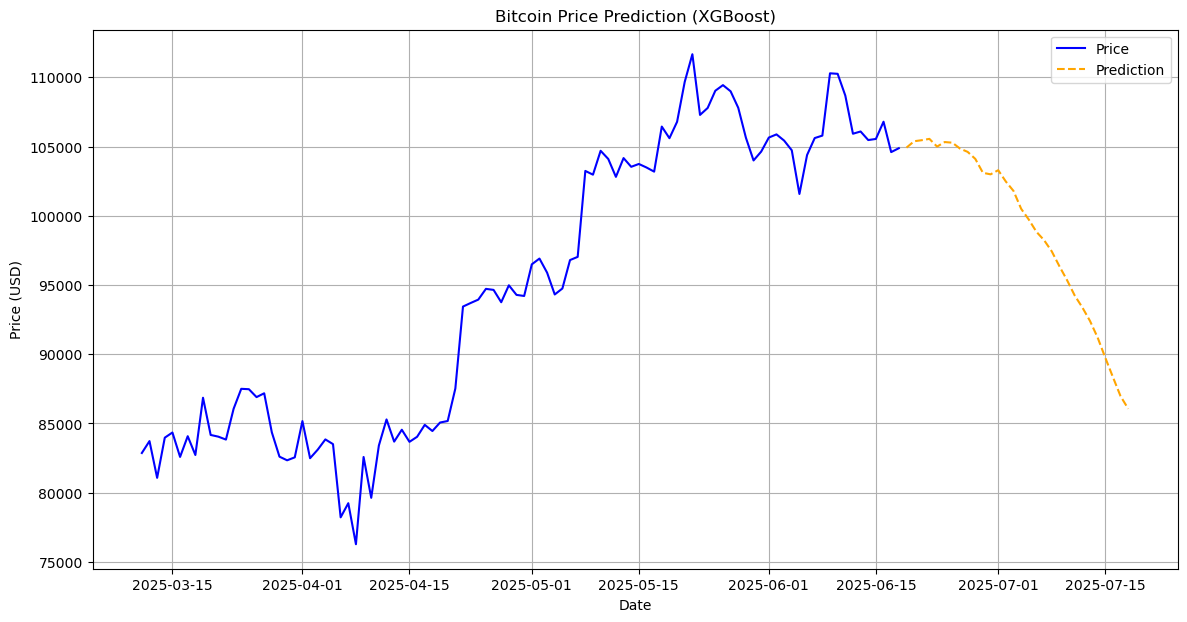

In [283]:
# Create dates for future predictions
last_date = btc.index[-1]
future_dates = pd.date_range(start=last_date, periods=len(predictions) +1)[1:]

# Plot results
plt.figure(figsize=(14, 7))
#plt.plot(data_2018.index[-100:], data_2018['target'][-100:], label='Historical Price')
#plt.plot(future_dates, predictions, label='60-day Prediction', linestyle='--', color='orange')
plt.plot(data_2018['date'][-100:], data_2018['price'][-100:], label='Price', color='blue')
plt.plot(future_df['Date'], future_df['Predicted_Price'], label='Prediction', linestyle='--', color='orange')
plt.title('Bitcoin Price Prediction (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [285]:
# Print predictions
print(f"\nPredicted Bitcoin Prices for Next {days_to_predict} Days:")
for i, (date, price) in enumerate(zip(dates, predictions), 1):
    print(f"Day {i:2d} ({date.strftime('%Y-%m-%d')}): ${price:,.2f}")


Predicted Bitcoin Prices for Next 30 Days:
Day  1 (2025-06-19): $104,922.91
Day  2 (2025-06-20): $105,386.27
Day  3 (2025-06-21): $105,462.05
Day  4 (2025-06-22): $105,557.57
Day  5 (2025-06-23): $104,999.24
Day  6 (2025-06-24): $105,328.09
Day  7 (2025-06-25): $105,281.56
Day  8 (2025-06-26): $104,856.82
Day  9 (2025-06-27): $104,617.91
Day 10 (2025-06-28): $104,112.55
Day 11 (2025-06-29): $103,104.84
Day 12 (2025-06-30): $102,995.67
Day 13 (2025-07-01): $103,293.27
Day 14 (2025-07-02): $102,472.31
Day 15 (2025-07-03): $101,794.83
Day 16 (2025-07-04): $100,505.03
Day 17 (2025-07-05): $99,724.99
Day 18 (2025-07-06): $98,840.27
Day 19 (2025-07-07): $98,237.72
Day 20 (2025-07-08): $97,431.49
Day 21 (2025-07-09): $96,358.17
Day 22 (2025-07-10): $95,351.67
Day 23 (2025-07-11): $94,243.23
Day 24 (2025-07-12): $93,380.04
Day 25 (2025-07-13): $92,405.94
Day 26 (2025-07-14): $91,205.41
Day 27 (2025-07-15): $89,749.60
Day 28 (2025-07-16): $88,346.92
Day 29 (2025-07-17): $86,966.16
Day 30 (2025

In [289]:
future_df

,Date,Predicted_Price
0,2025-06-19,104922.909935
1,2025-06-20,105386.274825
2,2025-06-21,105462.046023
3,2025-06-22,105557.568133
4,2025-06-23,104999.240977
5,2025-06-24,105328.088269
6,2025-06-25,105281.557478
7,2025-06-26,104856.817653
8,2025-06-27,104617.905837
9,2025-06-28,104112.552149


In [291]:
future_df.to_csv('xgboost_btc_price.csv', index=False)